# O que é o Tensorflow Probability?

Este é uma biblioteca que adiciona raciocínio probabilístico e análise estatística ao Tensorflow.

Através do TFP ([Github](https://github.com/tensorflow/probability) ou [site](https://www.tensorflow.org/probability)), podemos integrar métodos probabilísticos com redes profundas de forma simples, tomando vantagem das features do Tensorflow, como diferenciação automática, escalabilidade e etc, podendo criar o que chamados de Redes Neurais Bayesianas (BNNs - Bayesian Neural Networks), por exemplo.

Só para ter um pouco mais de noção sobre o quê estas redes são, vamos ver uma explicação bem básica sobre elas

# Redes Neurais Bayesianas - BNNs

Atualmente, as redes neurais profundas que conhecemos ficaram famosas por sua alta capacidade de entender padrões nos dados e ligá-los à alguma quantidade desejada (magnitudes e redshifts ou classes morfológicas, por exemplo). Porém, apenas este mapeamento não é suficiente para várias situações, sendo de extrema importância também obter estimativas da incerteza.

Como já falamos antes, existem dois tipos de incertezas que, quando somadas, resultam na incerteza preditiva, a incerteza 'total' de cada estimativa feita pela rede:
  1. Aleatória
  2. Epistêmica

De novo, uma medida da incerteza é essencial para entendermos quais são os limites dos nossos modelos e verificarmos a sua confiança nas predições.

O grande diferencial das BNNs é o fato de que cada peso da rede é uma distribuição, não um número único. Esta distribuição pode ser aprendida durante o processo de treinamento ou pode ser fixa.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1AcISq-SZS0UxOg4FDOO1ouiartkylpQN' />
<figcaption>Diferença entre uma rede neural normal e uma BNN.</figcaption></center>
</figure>

---

## Mas qual é a vantagem desse approach?

O 'problema' das redes neurais profundas é que elas maximizam a verossimilhança (maximum likelihood) da amostra de treinamento dado os parâmetros da rede (ou seja, $P(D|w)$), de forma que ela acaba sendo optimizada exclusivamente para o range de parâmetros que a amostra de treinamento abrange, diminuindo sua capacidade de generalização.

Podemos melhorar um pouco essa situação utilizando técnicas de regularização, como dropout, L1, L2, early-stopping e por aí vai. Porém ainda falta uma coisa neste tipo de rede: uma estimativa da incerteza da predições.

Não só isso, BNNs são mais robustas à over-fitting e tem maior capacidade de aprender a partir de conjuntos de dados menores.

--- 

Os parâmetros destas distribuições, que agora representam os pesos, são estimados com inferência Bayesiana, que usa o teorema de Bayes:

$P(w|D) \propto P(D|w) \cdot P(w)$, onde
* $P(w|D)$ é a distribuição posterior dos parâmetros;
* $P(D|w)$ é a verossimilhança dos dados;
* $P(w)$ é a distribuição à priori dos parâmetros.

Todo esse processo é muito pesado computacionalmente, talvez impossível para grandes redes. Por isso utilizamos aproximações como, por exemplo, aproximar a distribuição posterior como uma Gaussiana (posterior variacional - $q(w|D)$), ajustando os parâmetros desta distribuição para serem o mais próximo possível do posterior verdadeiro ($P(w|D)$). Isto é feito minimizando a divergência Kullback-Leibler entre esta distribuição simples e o posterior verdadeiro.

Algumas leituras: 
* [Bayesian Neural Network Series](https://medium.com/neuralspace/bayesian-neural-network-series-post-1-need-for-bayesian-networks-e209e66b70b2) (série com 8 posts sobre BNNs)
* [The very Basics of Bayesian Neural Networks](https://sanjaykthakur.com/2018/12/05/the-very-basics-of-bayesian-neural-networks/)
* [Knowing What You Know in Brain Segmentation Using Bayesian Deep Neural Networks](https://www.frontiersin.org/articles/10.3389/fninf.2019.00067/full) (fonte das imagens)
* [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#tensorflow)
* [Variational inference in Bayesian neural networks](http://krasserm.github.io/2019/03/14/bayesian-neural-networks/)
---

# Mas ok, como que podemos fazer um modelo e aplicá-lo em alguma coisa?


# **Tensorflow Probability - Primeiros passos**

Antes de tudo, devemos instalar o Tensorflow 2 para poder utilizar o Tensorflow Probability. O Colab usa o TF2 por padrão e já possui o TFP instalado.

Para instalar no seu computador é só usar o pip:

```
pip install tensorflow-probability
```

In [ ]:
# Checando a versão do Tensorflow
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
# Importando os pacotes que vamos utilizar neste notebook

# Tensorflow Probability
import tensorflow_probability as tfp
tfd = tfp.distributions # Este comando é para deixar o código mais sucinto

# Outros pacotes padrão
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
import numpy  as np
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()
plt.rcParams.update({'figure.figsize': (14,7)})
plt.rcParams.update({'axes.titlesize':  16})
plt.rcParams.update({'axes.labelsize':  12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'legend.fontsize': 12})

# Atualizando o Tensorflow Datasets (que será usado depois)
!pip install --upgrade tensorflow-datasets

## Regressão

O primeiro caso que vamos ver é uma aplicação bem simples do TFP em um problema de regressão em 4 etapas:
1. Modelo sem incertezas
2. Modelo com incerteza aleatória
3. Modelo com incerteza epistêmica
4. Modelo com as duas incertezas juntas

Referência: [Regression with Probabilistic Layers in TensorFlow Probability](https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html)

In [ ]:
#@title Função para criar um dataset sintético

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def fazer_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = fazer_dataset()

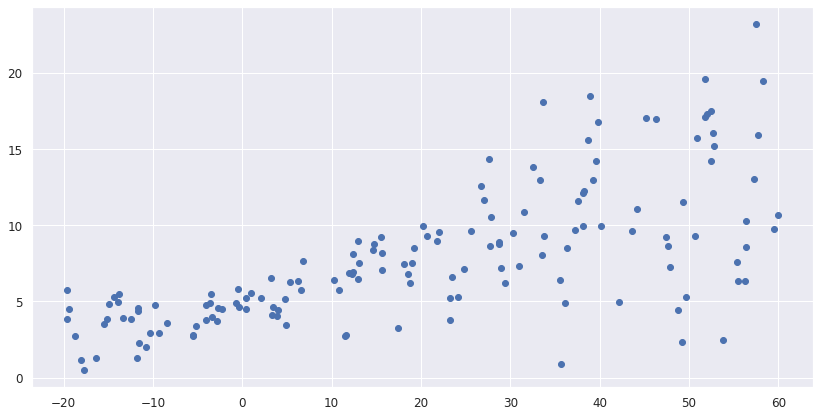

In [ ]:
# Plotando os dados
plt.plot(x, y, 'o')
plt.show()

In [ ]:
# Definindo a loss que vamos usar
def Negative_Log_Likelihood(y, p_y):
    return -p_y.log_prob(y)

### Modelo sem incertezas

In [ ]:
def Modelo_Simples():
  # Placeholder do Input
  Input_Layer = tf.keras.layers.Input(shape=np.shape(x)[1],)

  # Camadas ocultas
  L = tf.keras.layers.Dense(1)(Input_Layer)

  # Saída
  Out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(L)

  # Compilar modelo
  model = tf.keras.models.Model(inputs=Input_Layer, outputs=Out)
  model.compile(optimizer=tf.optimizers.Adam(lr=0.005, clipvalue=.5, clipnorm=.5), 
                loss=Negative_Log_Likelihood)
  return model

Modelo = Modelo_Simples()
Fit    = Modelo.fit(x, y, epochs=1000, verbose=0, callbacks=[TqdmCallback(verbose=0)])

Predictions = Modelo(x_tst)
Predictions

<tfp.distributions.Normal 'functional_59_distribution_lambda_28_Normal' batch_shape=[150, 1] event_shape=[] dtype=float32>

0.14027196
5.119735


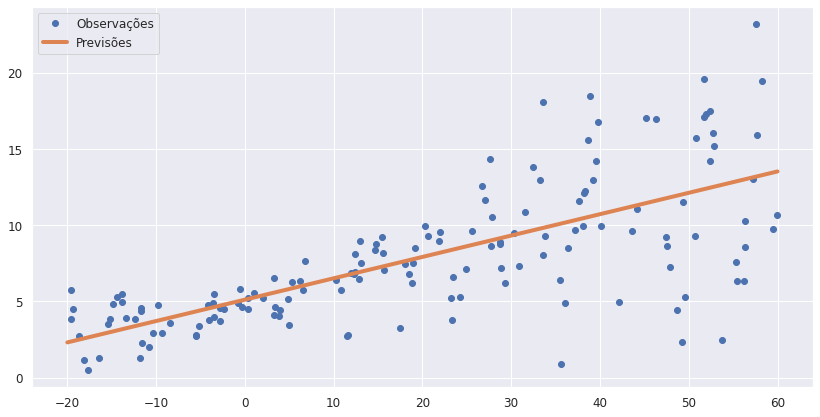

In [ ]:
[print(np.squeeze(w.numpy())) for w in Modelo.weights]

Mean = Predictions.mean()

plt.plot(x, y, 'o', label='Observações');
plt.plot(x_tst, Mean, '-', label='Previsões', linewidth=4)
plt.legend(loc='upper left')

plt.show()

### Modelo com incerteza aleatória

In [ ]:
def Modelo_Aleat():
  # Placeholder do Input
  Input_Layer = tf.keras.layers.Input(shape=np.shape(x)[1],)

  # Camadas ocultas
  L = tf.keras.layers.Dense(1+1)(Input_Layer)

  # Saída
  Out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-4 + tf.math.softplus(t[..., 1:])))(L)

  # Compilar modelo
  model = tf.keras.models.Model(inputs=Input_Layer, outputs=Out)
  model.compile(optimizer=tf.optimizers.Adam(lr=0.005, clipvalue=.5, clipnorm=.5), 
                loss=Negative_Log_Likelihood)
  return model

Modelo = Modelo_Aleat()
Fit    = Modelo.fit(x, y, epochs=1000, verbose=0, callbacks=[TqdmCallback(verbose=0)])

Predictions = Modelo(x_tst)
Predictions

<tfp.distributions.Normal 'functional_45_distribution_lambda_21_Normal' batch_shape=[150, 1] event_shape=[] dtype=float32>

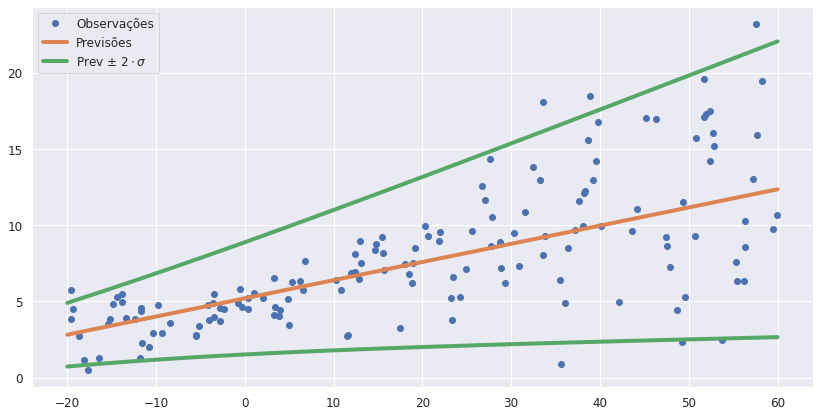

In [ ]:
Mean   = Predictions.mean()
StdDev = Predictions.stddev()

plt.plot(x, y, 'o', label='Observações')

plt.plot(x_tst, Mean, '-', label='Previsões', linewidth=4)
plt.plot(x_tst, Mean+2*StdDev, 'g', label='Prev $\pm$ $2\cdot\sigma$', linewidth=4)
plt.plot(x_tst, Mean-2*StdDev, 'g', linewidth=4)

plt.legend(loc='upper left')

plt.show()

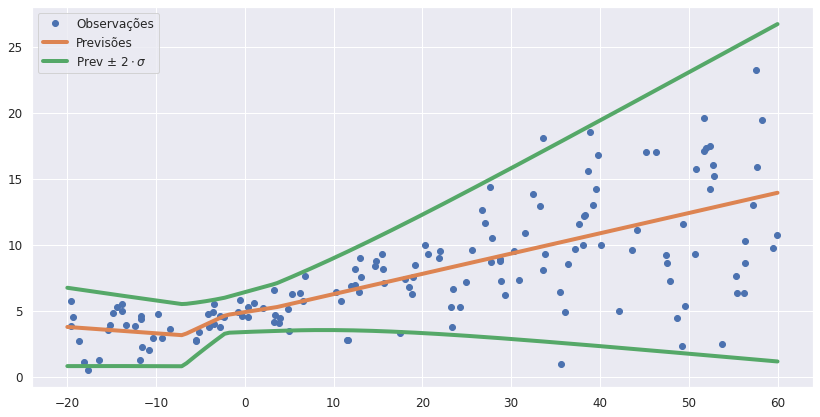

In [ ]:
def Modelo_Aleat():
  # Placeholder do Input
  Input_Layer = tf.keras.layers.Input(shape=np.shape(x)[1],)

  # Camadas ocultas
  L = tf.keras.layers.Dense(4, activation='relu')(Input_Layer)
  L = tf.keras.layers.Dense(1+1)(L)

  # Saída
  Out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-4 + tf.math.softplus(t[..., 1:])))(L)

  # Compilar modelo
  model = tf.keras.models.Model(inputs=Input_Layer, outputs=Out)
  model.compile(optimizer=tf.optimizers.Adam(lr=0.005, clipvalue=.5, clipnorm=.5), 
                loss=Negative_Log_Likelihood)
  return model

Modelo = Modelo_Aleat()
Fit    = Modelo.fit(x, y, epochs=500, verbose=0, callbacks=[TqdmCallback(verbose=0)])

Predictions = Modelo(x_tst)
Predictions

Mean   = Predictions.mean()
StdDev = Predictions.stddev()

plt.plot(x, y, 'o', label='Observações')

plt.plot(x_tst, Mean, '-', label='Previsões', linewidth=4)
plt.plot(x_tst, Mean+2*StdDev, 'g', label='Prev $\pm$ $2\cdot\sigma$', linewidth=4)
plt.plot(x_tst, Mean-2*StdDev, 'g', linewidth=4)

plt.legend(loc='upper left')

plt.show()

### Modelo com incerteza epistêmica

Para estimar a incerteza epistêmica nós utilizaremos uma camada específica do Tensorflow Probability, chamada de DenseVariational. Para utilizá-la é necessário mais duas definições: um **posterior** e um **prior**.

1. O posterior ($Q(w)$) que nós definimos é uma forma de representar a incerteza sobre o valor dos pesos do modelo;
2. O prior ($P(w)$) representa a incerteza dos pesos antes de olharmos para os dados.

A função desta camada é regularizar o posterior para que fique semelhante ao prior.

---

Como agora os pesos da rede não são exatos (as distribuições conferem incerteza a eles), toda vez que fizermos uma predição com esta rede obteremos um valor diferente, pois estamos fazendo amostragens destes pesos.

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1WSfhyGAsGXYRd0vkvjZXaAFF4aA2vkaW' />
<figcaption>Amostragem em uma BNN.</figcaption></center>
</figure>

Nas definições abaixo, o posterior é uma distribuição normal, na qual tanto a média quanto o desvio padrão podem ser treinados. Já o prior é uma distribuição normal com média treinável, porém o desvio padrão é fixo em 1.

In [ ]:
def Posterior(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
          tfp.layers.VariableLayer(2 * n, dtype=dtype),
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:]))))
  ])

In [ ]:
def Prior(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
         tfp.layers.VariableLayer(n, dtype=dtype),
         tfp.layers.DistributionLambda(lambda t: tfd.Independent(
         tfd.Normal(loc=t, scale=1)))
  ])

In [ ]:
def Modelo_Epist():
  # Placeholder do Input
  Input_Layer = tf.keras.layers.Input(shape=np.shape(x)[1],)

  # Camadas ocultas
  L = tfp.layers.DenseVariational(1, Posterior, Prior, kl_weight=1/len(x))(Input_Layer)

  # Saída
  Out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))(L)

  # Compilar modelo
  model = tf.keras.models.Model(inputs=Input_Layer, outputs=Out)
  model.compile(optimizer=tf.optimizers.Adam(lr=0.005, clipvalue=1, clipnorm=1), 
                loss=Negative_Log_Likelihood)
  return model

Modelo = Modelo_Epist()
Fit    = Modelo.fit(x, y, epochs=1000, verbose=0, callbacks=[TqdmCallback(verbose=0)])

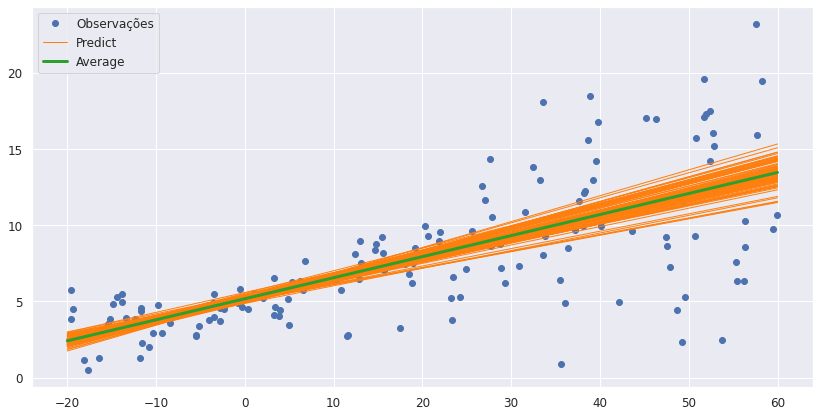

In [ ]:
plt.plot(x, y, 'o', label='Observações')

All_Mean = 0

for i in range(100):
  Predictions = Modelo(x_tst)
  Mean        = Predictions.mean()
  plt.plot(x_tst, Mean, 'r', color='#ff7f0e', label='Predict' if i==0 else None, linewidth=1)
  All_Mean    += Mean

plt.plot(x_tst, All_Mean/100, color='#2ca02c', label='Average', linewidth=3)
plt.legend(loc='upper left')

plt.show()

### Modelo com as duas incertezas juntas

In [ ]:
def Modelo_Total():
  # Placeholder do Input
  Input_Layer = tf.keras.layers.Input(shape=np.shape(x)[1],)

  # Camadas ocultas
  L = tfp.layers.DenseVariational(1+1, Posterior, Prior, kl_weight=1/len(x))(Input_Layer)

  # Saída
  Out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-4 + tf.math.softplus(t[..., 1:])))(L)

  # Compilar modelo
  model = tf.keras.models.Model(inputs=Input_Layer, outputs=Out)
  model.compile(optimizer=tf.optimizers.Adam(lr=0.005, clipvalue=1, clipnorm=1), 
                loss=Negative_Log_Likelihood)
  return model

Modelo = Modelo_Total()
Fit    = Modelo.fit(x, y, epochs=1000, verbose=0, callbacks=[TqdmCallback(verbose=0)])

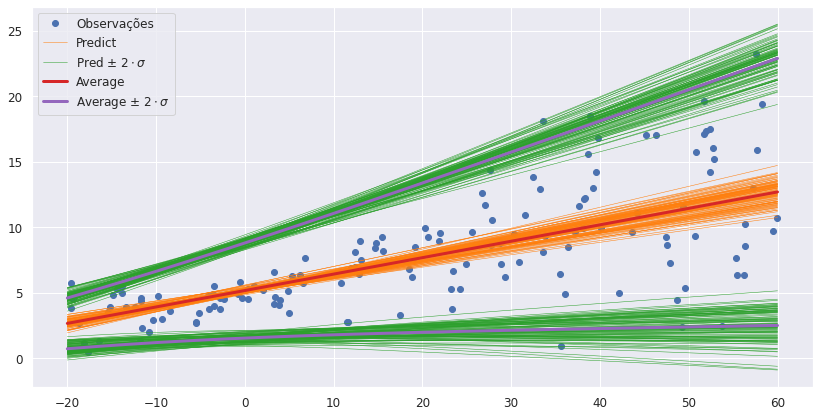

In [ ]:
plt.plot(x, y, 'o', label='Observações')

All_Mean = 0
All_Std  = 0

for i in range(100):
  Predictions = Modelo(x_tst)
  Mean        = Predictions.mean()
  StdDev      = Predictions.stddev()
  plt.plot(x_tst, Mean, '-', color='#ff7f0e', label='Predict' if i==0 else None, linewidth=.5)
  plt.plot(x_tst, Mean+2*StdDev, '-', color='#2ca02c', label='Pred $\pm$ $2\cdot\sigma$' if i==0 else None, linewidth=.5)
  plt.plot(x_tst, Mean-2*StdDev, '-', color='#2ca02c', linewidth=.5)
  All_Mean += Mean
  All_Std  += StdDev

plt.plot(x_tst, All_Mean/100, color='#d62728', label='Average', linewidth=3)
plt.plot(x_tst, (All_Mean/100)+2*(All_Std/100), color='#9467bd', label='Average $\pm$ $2\cdot\sigma$', linewidth=3)
plt.plot(x_tst, (All_Mean/100)-2*(All_Std/100), color='#9467bd', linewidth=3)

plt.legend(loc='upper left')

plt.show()

Após treinar este modelo e fazer uma amostragem grande (várias predições), podemos calcular as três incertezas (aleatória, epistêmica e preditiva) utilizando os valores das médias e variâncias das predições

In [ ]:
Medias     = []
Variancias = []

for i in range(100):
  Pred = Modelo(x_tst)

  Medias.append(Pred.mean())
  Variancias.append(Pred.variance())

Pred_Mean = np.mean(Medias, axis=0)       # Estimativa de ponto único
Epis_Unc  = np.var(Medias, axis=0)        # Incerteza epistêmica (do modelo)
Alea_Unc  = np.mean(Variancias, axis=0)   # Incerteza aleatória (dos dados)
Pred_Unc  = Epis_Unc + Alea_Unc           # Incerteza total

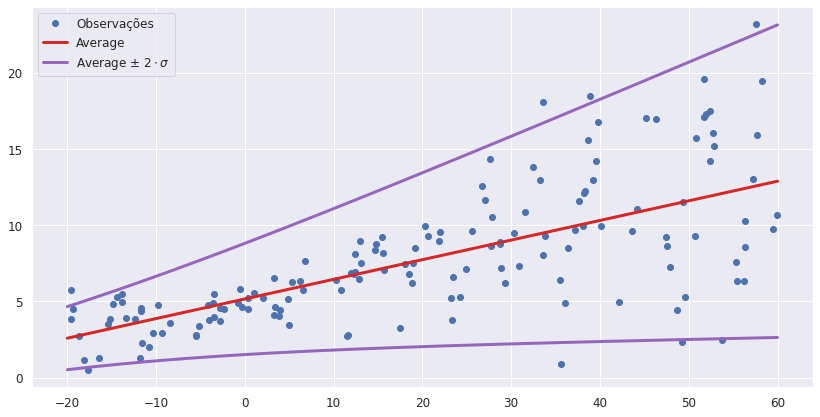

In [ ]:
plt.plot(x, y, 'o', label='Observações')

plt.plot(x_tst, Pred_Mean, color='#d62728', label='Average', linewidth=3)
plt.plot(x_tst, Pred_Mean+2*np.sqrt(Pred_Unc), color='#9467bd', label='Average $\pm$ $2\cdot\sigma$', linewidth=3)
plt.plot(x_tst, Pred_Mean-2*np.sqrt(Pred_Unc), color='#9467bd', linewidth=3)

plt.legend(loc='upper left')

plt.show()

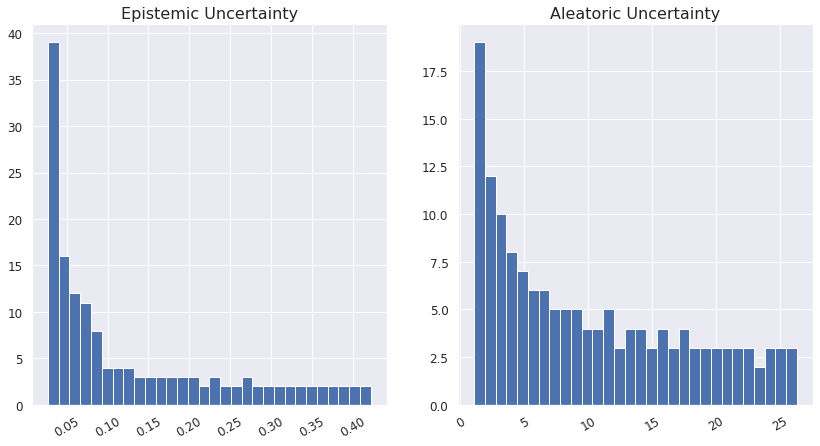

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,7))

ax[0].hist(Epis_Unc, bins=30); ax[0].set_title('Epistemic Uncertainty')
ax[1].hist(Pred_Unc, bins=30); ax[1].set_title('Aleatoric Uncertainty')

ax[0].tick_params(axis='x', labelrotation=30)
ax[1].tick_params(axis='x', labelrotation=30)

plt.show()

## Variational Autoencoder

Referência: [aqui](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE) ou [aqui, mais detalhado](https://morioh.com/p/75a221a1e48e)

In [ ]:
import tensorflow_datasets as tfds

tfk  = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd  = tfp.distributions

In [ ]:
datasets, datasets_info = tfds.load(name='mnist', with_info=True, as_supervised=False)

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255
  image = image < tf.random.uniform(tf.shape(image))
  return image, image

train_dataset = (datasets['train'].map(_preprocess).batch(256).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e3)))
eval_dataset = (datasets['test'].map(_preprocess).batch(256).prefetch(tf.data.experimental.AUTOTUNE))

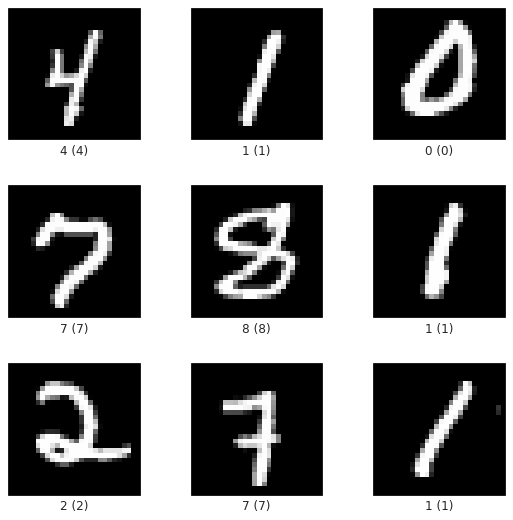

In [ ]:
fig = tfds.show_examples(datasets['train'], datasets_info)

In [ ]:
Input_Shape  = datasets_info.features['image'].shape
Encoded_Size = 16

In [ ]:
Prior = tfd.Independent(tfd.Normal(loc=tf.zeros(Encoded_Size), scale=1), reinterpreted_batch_ndims=1)

In [ ]:
Encoder = tf.keras.models.Sequential()
Encoder.add( tfkl.InputLayer(input_shape=Input_Shape) )
Encoder.add( tfkl.Conv2D(32, 5, 1, padding='same', activation='relu') )
Encoder.add( tfkl.Conv2D(32, 5, 2, padding='same', activation='relu') )
Encoder.add( tfkl.Conv2D(64, 5, 1, padding='same', activation='relu') )
Encoder.add( tfkl.Conv2D(64, 5, 2, padding='same', activation='relu') )
Encoder.add( tfkl.Conv2D(64, 7, 1, padding='valid', activation='relu') )
Encoder.add( tfkl.Flatten() )
Encoder.add( tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(Encoded_Size)) )
Encoder.add( tfpl.MultivariateNormalTriL(Encoded_Size, activity_regularizer=tfpl.KLDivergenceRegularizer(Prior)))

In [ ]:
Decoder = tf.keras.models.Sequential()
Decoder.add( tfkl.InputLayer(input_shape=[Encoded_Size]) )
Decoder.add( tfkl.Reshape([1, 1, Encoded_Size]) )
Decoder.add( tfkl.Conv2DTranspose(64, 7, 1, padding='valid', activation='relu') )
Decoder.add( tfkl.Conv2DTranspose(64, 5, 1, padding='same', activation='relu') )
Decoder.add( tfkl.Conv2DTranspose(64, 5, 2, padding='same', activation='relu') )
Decoder.add( tfkl.Conv2DTranspose(32, 5, 1, padding='same', activation='relu') )
Decoder.add( tfkl.Conv2DTranspose(32, 5, 2, padding='same', activation='relu') )
Decoder.add( tfkl.Conv2DTranspose(32, 5, 1, padding='same', activation='relu') )
Decoder.add( tfkl.Conv2D(1, 5, 1, padding='same') )
Decoder.add( tfkl.Flatten() )
Decoder.add( tfpl.IndependentBernoulli(Input_Shape, tfd.Bernoulli.logits) )

In [ ]:
VAE = tfk.Model(inputs=Encoder.inputs, outputs=Decoder(Encoder.outputs[0]))
VAE.compile(optimizer=tf.optimizers.Adam(), loss=Negative_Log_Likelihood)

In [ ]:
Fit = VAE.fit(train_dataset, epochs=15, validation_data=eval_dataset, verbose=0, callbacks=[TqdmCallback(verbose=0)])

In [ ]:
# We'll just examine ten random digits.
Test_Samples = next(iter(eval_dataset))[0][:10]
Predict      = VAE(Test_Samples)
assert isinstance(Predict, tfd.Distribution)

In [ ]:
def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))

  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()
  plt.ion()

Originals:


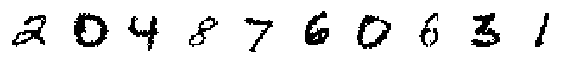

Decoded Random Samples:


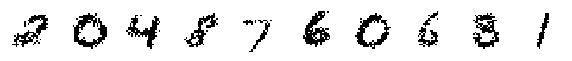

Decoded Modes:


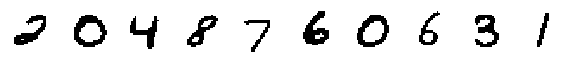

Decoded Means:


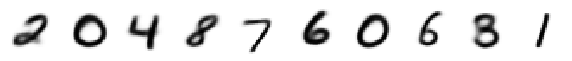

Decoded Std. Devs.:


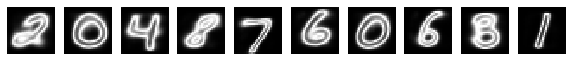

Decoded Variances:


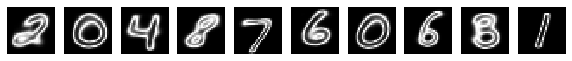

In [128]:
print('Originals:')
display_imgs(Test_Samples)

print('Decoded Random Samples:')
display_imgs(Predict.sample())

print('Decoded Modes:')
display_imgs(Predict.mode())

print('Decoded Means:')
display_imgs(Predict.mean())

print('Decoded Std. Devs.:')
display_imgs(Predict.stddev())

print('Decoded Variances:')
display_imgs(Predict.variance())

In [ ]:
Random_Noise = Prior.sample(10)
Generated    = Decoder(Random_Noise)
assert isinstance(Generated, tfd.Distribution)

Randomly Generated Samples:


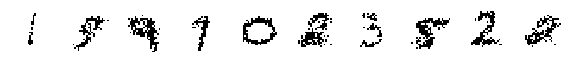

Randomly Generated Modes:


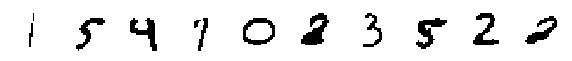

Randomly Generated Means:


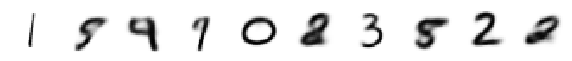

In [ ]:
print('Randomly Generated Samples:')
display_imgs(Generated.sample())

print('Randomly Generated Modes:')
display_imgs(Generated.mode())

print('Randomly Generated Means:')
display_imgs(Generated.mean())

## Outros tipos de rede

O uso do TFP não é restrito à problemas de regressão e classificação. Pode também ser usado em
* Autoencoders Variacionais: [exemplo](https://towardsdatascience.com/6-different-ways-of-implementing-vae-with-tensorflow-2-and-tensorflow-probability-9fe34a8ab981)
* Processos Gaussianos: [exemplo 1](https://www.tensorflow.org/probability/examples/Gaussian_Process_Regression_In_TFP), [exemplo 2](https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html)
* PCA Probabilístico: [exemplo](https://www.tensorflow.org/probability/examples/Probabilistic_PCA)
* Mixture Density Networks: [exemplo 1](https://medium.com/@bhatia.vidit/mixture-density-network-tensorflow-probability-and-estimators-717edd222286), [exemplo 2](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca)
